In [166]:
import math, copy, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

In [167]:
class Sensors:
    def __init__(self,id, type, x, y, x_e = 0, y_e = 0, energy = 10):
        self.id = id
        self.type = type
        self.x = x
        self.y = y
        self.x_e = x_e
        self.y_e = y_e
        self.energy = energy

In [168]:
error_overall = []


### Function to find virtual anchor nodes

In [169]:
def find_virtual_anchors(x,y,d):
    anchors=[]
    anchors.append([x+d*np.cos(np.pi/3),y+d*np.sin(np.pi/3)])
    anchors.append([x+d,y])
    anchors.append([x-d,y]);
    anchors.append([x+d*np.cos(np.pi/3),y-d*np.sin(np.pi/3)]);
    anchors.append([x-d*np.cos(np.pi/3),y-d*np.sin(np.pi/3)]);
    anchors.append([x-d*np.cos(np.pi/3),y+d*np.sin(np.pi/3)]);
    return anchors

### Function to elect new anchor node

In [170]:
def elect_anchor(anchor, sensor):
    maximum_energy = 0
    new_anchor = 0
    for i in range(len(sensor)):
        if sensor[i].type == 'target' and sensor[i].energy >= maximum_energy:
            maximum_energy = sensor[i].energy
            new_anchor = i
            
#     print(old_anchor)
    anchor = copy.deepcopy(sensor[new_anchor])
    anchor.type = 'anchor'
    del sensor[new_anchor]
    
    return anchor, sensor    

### Optimization Function

In [171]:
def Fun(x,y, anchors, target):
    f = 0
    for i in range(3):
        d = math.dist([target[0],target[1]], [anchors[i][0],anchors[i][1]])
        d1= math.dist([x,y],[anchors[i][0],anchors[i][1]])
        f +=  math.pow( abs(d1 - d),2)
    return f/3

### NMRA optimizer function

In [172]:
def NMRA(maxIter,best,n,anchors,target,lb,ub, error_each_epoch):
    

    x_lb,y_lb,x_ub,y_ub=lb[0], lb[1], ub[0], ub[1]

    
    rats=[]
    # 24
    workers=n-n//5 
    # 6
    breeders=n//5
    fitness=[]
    bp=0.3
   
    # First rat is at centroid
    rats.append([x_lb - 1, y_lb-1])
    fitness.append(Fun(x_lb - 1, y_lb-1,anchors,target))
    # Initializing random rats and calculating their fitness
    for i in range(n-1):
        x1=x_lb+np.random.random()*(x_ub-x_lb)
        y1=y_lb+np.random.random()*(y_ub-y_lb)
        rats.append([x1,y1])
        fitness.append(Fun(x1,y1,anchors,target))
    
    sorted_fitness = []
    for i in range(n):
        l = [fitness[i],i]
        sorted_fitness.append(l)
    sorted_fitness.sort()
    
    
    for itr in range(maxIter):
        S = copy.deepcopy(rats)
        ratBest=rats[sorted_fitness[0][1]]
        
        # Workers phase
        
        for i in range(breeders, n):
            ab = []
            for j in range(breeders, n):
                ab.append(sorted_fitness[j][1])
            idx = sorted_fitness[i][1]
            lmda = np.random.random()
            random.shuffle(ab)
            # print(lmda)
            S[idx][0] = S[idx][0] + lmda * (S[ab[0]][0] - S[ab[1]][0])
            S[idx][1] = S[idx][1] + lmda * (S[ab[0]][1] - S[ab[1]][1])
            # Calculating and updating new fitness and rat's coordinates
            fnew = Fun(S[idx][0], S[idx][1], anchors, target)
            if fnew < fitness[idx]:
                fitness[idx] = fnew
                rats[idx]= S[idx]
        
        # Breeders phase
        for i in range(breeders):
            if np.random.random() > bp:
                lmda = np.random.random()
                idx = sorted_fitness[i][1]
                
                S[idx][0] = (1-lmda)*S[idx][0] + lmda*(ratBest[0] - S[idx][0])
                S[idx][1] = (1-lmda)*S[idx][1] + lmda*(ratBest[1] - S[idx][1])
                fnew = Fun(S[idx][0], S[idx][1], anchors, target)
                if fnew < fitness[idx]:
                    fitness[idx] = fnew
                    rats[idx]= S[idx]
                    
        # Updating sorted fitness list
        sorted_fitness.clear()
        for i in range(n):
            l = [fitness[i],i]
            sorted_fitness.append(l)
        sorted_fitness.sort()
        idx = sorted_fitness[0][1]
        error_each_epoch.append(math.dist(rats[idx], target))
        
        # Uncomment this to show the process
#         if itr==0 or itr==10 or itr==20 or itr==39:
#             idx_graph=sorted_fitness[0][1]
#             r=np.array(rats)
#             an=np.array(anchors)
#             xr,yr=r.T
#             xa,ya=an.T
#             fig,ax=plt.subplots()
#             ax.set_xlim(0,15)
#             ax.set_ylim(0,15)
            
#             ax.scatter(xr,yr,marker='2',s=75,label="Mole Rats")
        
#             ax.scatter(xa[0], ya[0], marker = 'D', c = "slateblue",s=100,label="Anchor Node")
#             ax.scatter(xa[1], ya[1], marker = 'o', c = "teal",s=100,label="Virtual Anchor Node")
#             ax.scatter(xa[2], ya[2], marker = 'o', c = "teal",s=100)
#             ax.scatter(target[0],target[1], marker='^',s=100,label="Target Node",c="hotpink")
#             ax.scatter(rats[idx_graph][0],rats[idx_graph][1], marker='v',s=100,label="Estimated Position",c="orange")
#             plt.legend()
#             plt.show()
#         print(rats[idx_graph])
#         print(sorted_fitness[0][0])

    
    idr=sorted_fitness[0][1]
    #print(rats[idr])
    
    return rats[idr]

### Constants and deploying nodes

In [173]:
no_of_movements = 10
no_of_target_nodes = 20
anchor1 = [7.5,7.5]
target_nodes=[]
sensor = []
anchor = Sensors(0, 'anchor', 7.5, 7.5, 7.5, 7.5)
dead_nodes = 0;
energy_table= []


x_target=np.random.uniform(0,15,no_of_target_nodes)
y_target=np.random.uniform(0,15,no_of_target_nodes)

for i in range(no_of_target_nodes):
    s = Sensors(i+1, 'target', x_target[i], y_target[i])
    sensor.append(s)
# print(sensor)
    
    

In [174]:
predicted_C = []
original_C = []
anchor_Energy = []
dist_table= []
dead_nodes = 0
energy_table= []
alive_count = []
energy_table.append([0, f"({round(anchor.x,2)},{round(anchor.y,2)})", round(anchor.energy,3), dead_nodes])

# Adding random mobility to the target nodes
for i in range(no_of_movements):
    error_this_movement = []
    predicted=[]
    original=[]
    anchor_Energy.append(anchor.energy)
    for k in range(len(sensor)):
        sensor[k].x+=0.1*random.uniform(-15,15)
        sensor[k].y+=0.1*random.uniform(-15,15)
        if sensor[k].x<0 or sensor[k].x>15:
            sensor[k].x=random.uniform(0,15)
        if sensor[k].y<0 or sensor[k].y>15:
            sensor[k].y=random.uniform(0,15)
        energy = sensor[k].energy - np.random.random()
        sensor[k].energy = energy
    
    for k in range(len(sensor)):
        error_each_epoch = []
        dist_list = []
        # Finding 2 Virtual Anchor nodes with shortest distance from target node
        dist_list.append(k+1)
        dist_list.append(i+1)
        anchors = [[anchor.x,anchor.y]]
        d = math.dist([sensor[k].x,sensor[k].y], [anchor.x,anchor.y])
        virtual_anchors=find_virtual_anchors(anchor.x,anchor.y, d)
        va_dist=[]
        for j in range(len(virtual_anchors)):
            dist=math.dist([sensor[k].x,sensor[k].y],[virtual_anchors[j][0],virtual_anchors[j][1]])
            l=[dist,j]
            va_dist.append(l)
            dist_list.append(dist)
        va_dist.sort()
        idx1,idx2=va_dist[0][1],va_dist[1][1]
        va1,va2=virtual_anchors[idx1],virtual_anchors[idx2]
        anchors.append(va1)
        anchors.append(va2)
        centroid_x,centroid_y=(va1[0]+va2[0]+anchor.x)/3,(va1[1]+va2[1]+anchor.y)/3

        lb = [centroid_x-d, centroid_y-d]
        ub = [centroid_x+d, centroid_y+d]

#       Optimizing using NMRA
        coordinates=NMRA(60,3,30,anchors,[sensor[k].x,sensor[k].y],lb,ub, error_each_epoch)
#         print(coordinates)
        predicted.append(coordinates)
        original.append([sensor[k].x,sensor[k].y])
        sensor[k].x_e = coordinates[0]
        sensor[k].y_e = coordinates[1]
        error_this_movement.append(error_each_epoch)

        dist_table.append(dist_list)
    
    error_overall.append(error_this_movement)
    predicted_C.append(predicted)
    original_C.append(original)

    # [movement no., anchor cooridinates, energy, dead_anchors]
    energy_tracker = []
    
    if anchor.energy>=2:
        energy = anchor.energy - 10 * np.random.random()
        anchor.energy = energy
        
    if anchor.energy<2:
        dead_nodes+=1
        anchor, sensor = elect_anchor(anchor, sensor)
        anchor.x = anchor.x_e
        anchor.y = anchor.y_e
    energy_tracker.extend([i+1, f"({round(anchor.x,2)},{round(anchor.y,2)})", round(anchor.energy,3), dead_nodes])
    energy_table.append(energy_tracker)
    alive_count.append(no_of_target_nodes - dead_nodes)

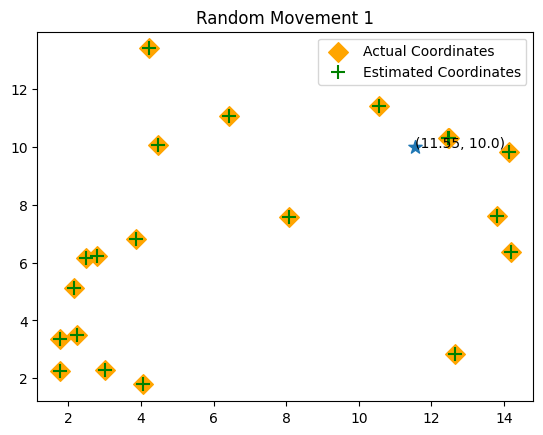

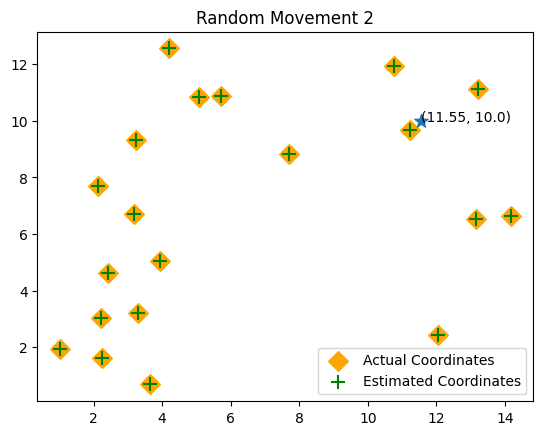

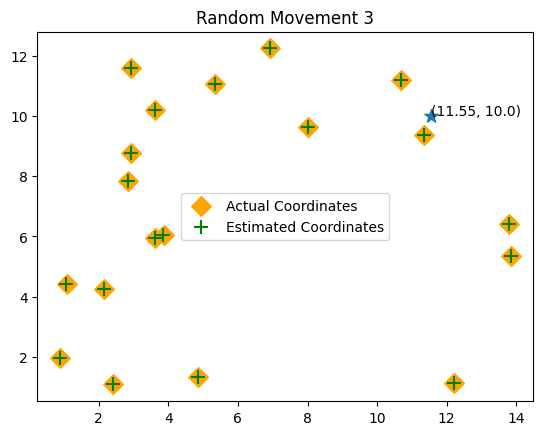

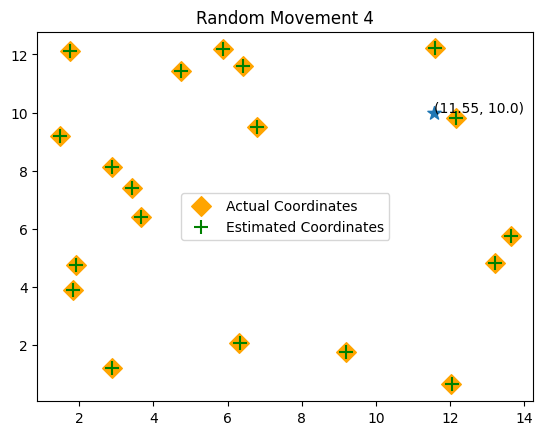

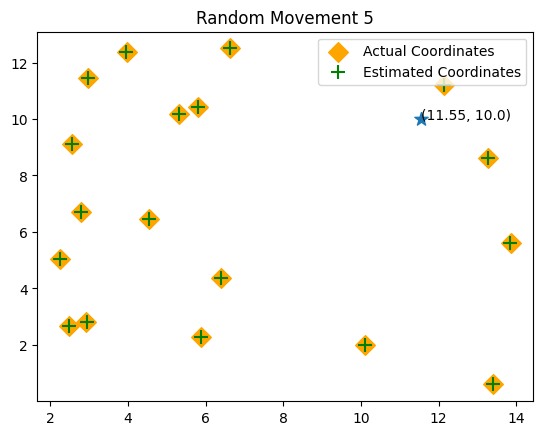

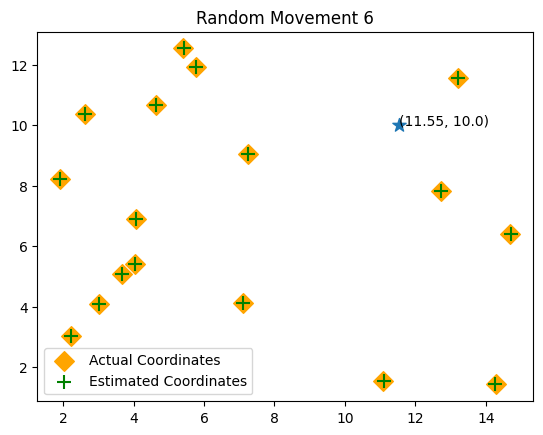

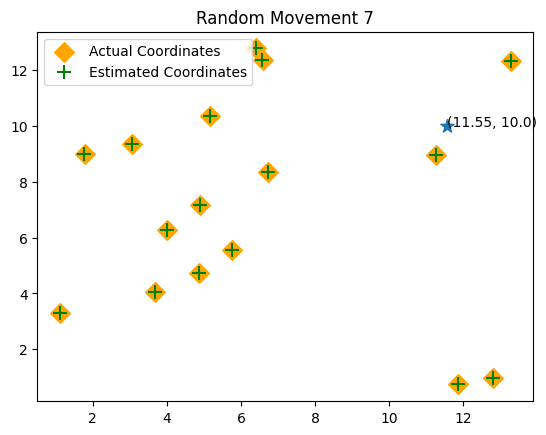

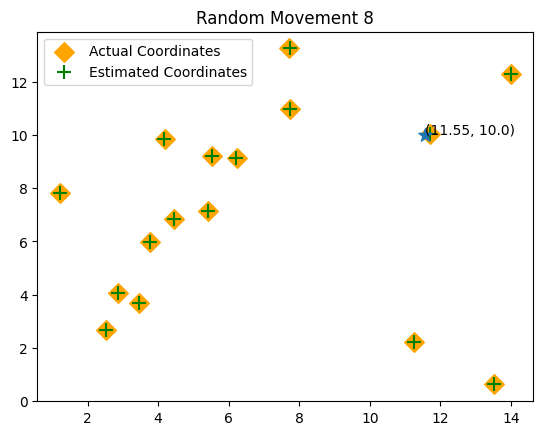

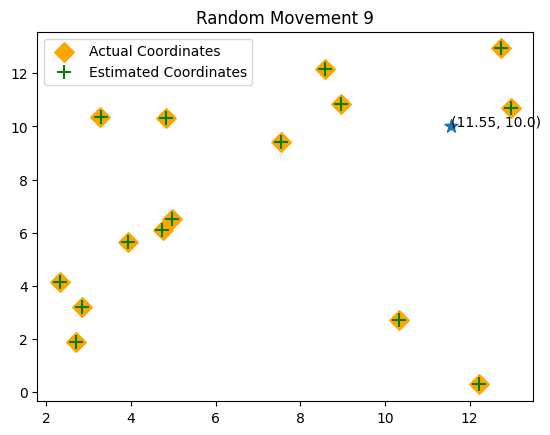

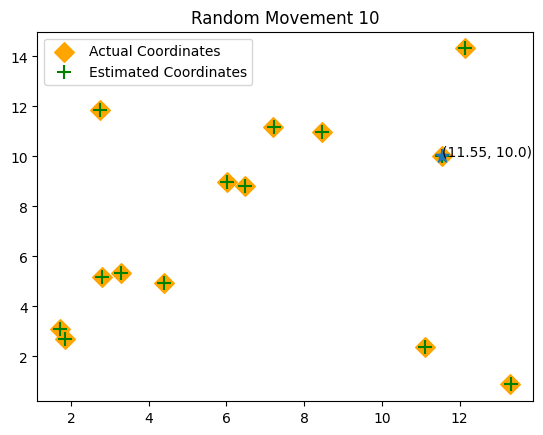

In [179]:
for i in range(no_of_movements):
    predicted = np.array(predicted_C[i])
    predicted_x, predicted_y = predicted.T

    original = np.array(original_C[i])
    original_x, original_y = original.T
      
    title = 'Random Movement '+ str(i +1)
    
    plt.title(title)
    plt.scatter(original_x, predicted_y, marker = 'D', s = 100, c = 'Orange', label = 'Actual Coordinates')
    plt.scatter(predicted_x, predicted_y, marker = '+', s = 100, c = 'green', label = 'Estimated Coordinates')
    plt.scatter(anchor.x,anchor.y,marker='*',s = 100)
    plt.text(anchor.x, anchor.y, '({}, {})'.format(round(anchor.x,2), round(anchor.y,2)))
    plt.legend()
    plt.show()



### Tables

#### Distance table

In [ ]:
distance_df = pd.DataFrame(dist_table, columns=["Unknown Nodes","Movement No.", "VA1", "VA2", "VA3", "VA4", "VA5", "VA6"])    
# print(len(predicted_C[0]),len(original_C[0]))
distance_df = distance_df.sort_values(by=["Unknown Nodes", "Movement No."], ascending=True)
distance_df.to_csv('dist_table.csv', index = False)
print(distance_df.head(10).to_string(index=False))

 Unknown Nodes  Movement No.       VA1       VA2       VA3       VA4       VA5      VA6
             1             1  3.625276  7.762553  6.194585  9.819861  9.245944 1.483391
             1             2  5.017704  9.912169  7.132971 12.150675 11.133418 1.221250
             1             3  5.894681 11.565106  8.241989 14.136670 12.920325 1.355219
             1             4  0.476380  6.683216 12.528429 12.052049 14.191546 7.508330
             1             5  9.744184 17.978640 11.651549 21.395733 19.079857 1.101218
             1             6 10.721330 19.416212 12.187207 22.908537 20.262537 0.846325
             1             7 10.989733 19.324410 11.491393 22.481126 19.614043 0.289633
             1             8 12.656592 21.494844 11.916977 24.573569 21.067826 0.427017
             1             9  6.909463 15.286048 12.657285 19.566749 18.604555 3.318507
             1            10  6.039908 15.446086 14.673591 20.713499 20.430746 4.984660


#### Energy Table

In [ ]:
energy_df = pd.DataFrame(energy_table, columns=["Movement no.", "Anchor Cooridinates", "Energy", "Dead Anchors"])
print(energy_df.to_string(index=False))
energy_df.to_csv('Energy_table.csv', index = False)

 Movement no. Anchor Cooridinates  Energy  Dead Anchors
            0           (7.5,7.5)  10.000             0
            1           (7.5,7.5)   9.601             0
            2           (7.5,7.5)   3.708             0
            3          (2.32,7.9)   9.348             1
            4         (10.5,3.33)   8.551             2
            5         (10.5,3.33)   6.139             2
            6         (10.5,3.33)   5.898             2
            7         (10.5,3.33)   5.479             2
            8         (6.55,3.01)   7.256             3
            9         (6.22,2.54)   6.295             4
           10         (6.22,2.54)   2.542             4


#### Energy vs movement

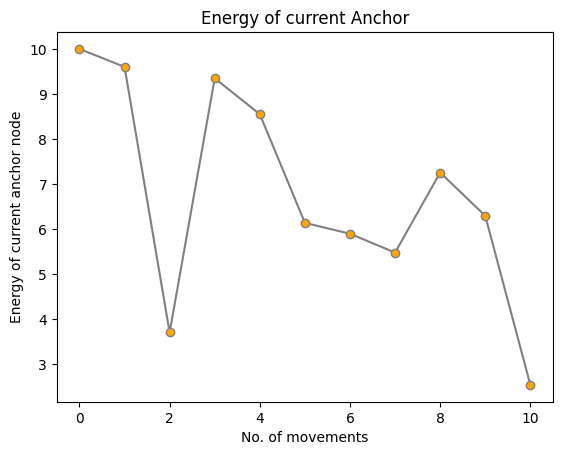

In [ ]:
plt.plot(energy_df['Movement no.'], energy_df['Energy'], linestyle = "solid",marker = 'o' ,color = 'gray', markerfacecolor = 'orange')
plt.title("Energy of current Anchor")
plt.xlabel('No. of movements')
plt.ylabel('Energy of current anchor node')
plt.show()

#### Energy vs Dead Anchors

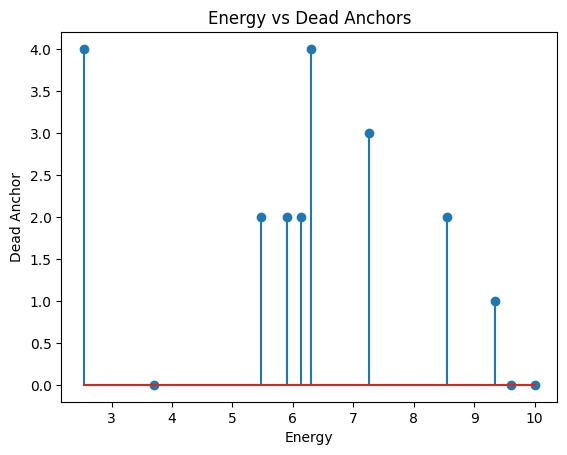

In [ ]:
# energy_df.plot(x="Movement no.", y = "Energy")
plt.stem(energy_df['Energy'], energy_df['Dead Anchors'])
plt.title('Energy vs Dead Anchors')
plt.xlabel("Energy")
plt.ylabel("Dead Anchor")
plt.show()

#### Alive nodes vs energy

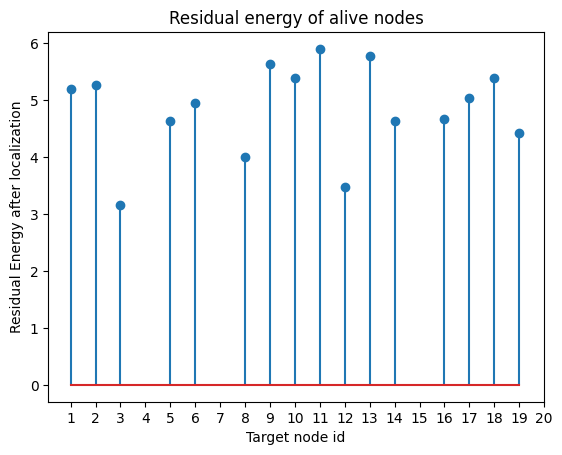

In [ ]:
ids = []

for k in range(len(sensor)):
    temp = []
    temp.append(sensor[k].id)
    temp.append(sensor[k].energy)
    ids.append(temp)

target_energy_df = pd.DataFrame(ids, columns=['id', 'energy'])
target_energy_df.to_csv('Energy_table_target.csv', index = False)

plt.stem(target_energy_df['id'],target_energy_df['energy'])
plt.title('Residual energy of alive nodes')
plt.xticks(np.arange(1,21))
plt.xlabel("Target node id")
plt.ylabel("Residual Energy after localization")
plt.show()


#### No. of alive nodes at each movement

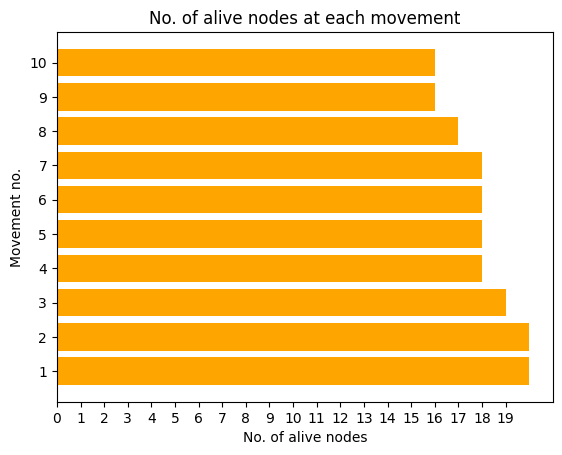

In [ ]:
x_axis = np.arange(1,no_of_movements+1)
y_axis = np.arange(no_of_target_nodes)
plt.barh(x_axis,alive_count,color = 'orange')
plt.title('No. of alive nodes at each movement')
plt.yticks(x_axis)
plt.xticks(y_axis)
plt.ylabel("Movement no.")
plt.xlabel("No. of alive nodes")
plt.show()

### Error Calculation

[ 1  2  3  4  5  6  7  8  9 10]


[Text(0.5, 0, 'Movement Number'),
 Text(0, 0.5, 'Error'),
 Text(0.5, 1.0, 'Errors vs Movement')]

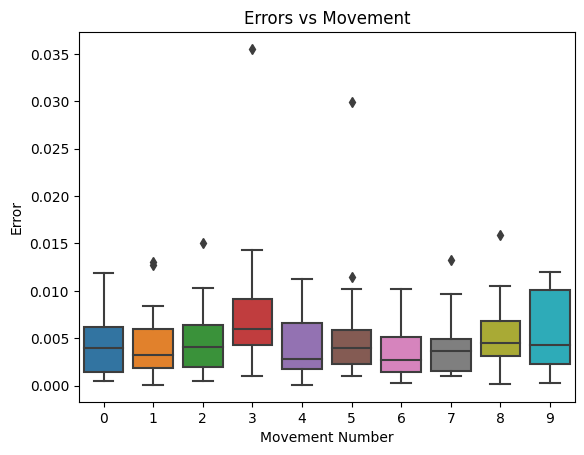

In [ ]:
min_error = []
avg_error = []
max_error = []
error_movement=[]
xaxis = np.arange(1,no_of_movements+1)
print(xaxis)
for i in range(no_of_movements):
    error = []
    avg_e = 0
    no_of_target_nodes = len(predicted_C[i])
    for j in range(len(predicted_C[i])):
        e = math.dist(predicted_C[i][j], original_C[i][j])
        avg_e += e
        error.append(e)
    avg_e/=no_of_target_nodes
    
    max_e = max(error)
    min_e = min(error)
    error_movement.append(error)
    avg_error.append(avg_e*10)
    max_error.append(max_e*10)
    min_error.append(min_e*10)

# print(min_error)
# print(avg_error)
# print(max_error)
# print(error_movement)
# plt.bar(xaxis - 0.25, min_error, 0.25, label = 'Min Error')
# plt.bar(xaxis, max_error, 0.25 , label = 'Max Error')
# plt.bar(xaxis + 0.25, avg_error,0.25, label = 'average Error')
# plt.legend()
# plt.xlabel('No. of movements')
# plt.show()
ax = sns.boxplot(data=error_movement)
ax.set(xlabel="Movement Number", ylabel = "Error", title= "Errors vs Movement")


In [ ]:
FA_avg_error = [2.3594, 3.0538, 2.4412, 3.136, 2.6024]
BBO_avg_error = [0.3838, 0.8227, 0.6926, 0.7984, 0.9317]
PSO_avg_error = [0.7048,1.1338,0.8236,0.5982, 0.7536]
HPSO_avg_error = [0.2449,0.3536,0.3338,0.3491,0.2209]
NMRA_avg_error = avg_error[:5]
print(NMRA_avg_error)

[0.04270402163098531, 0.04420260801168644, 0.04713844074125283, 0.07870883875233545, 0.04191832666021761]


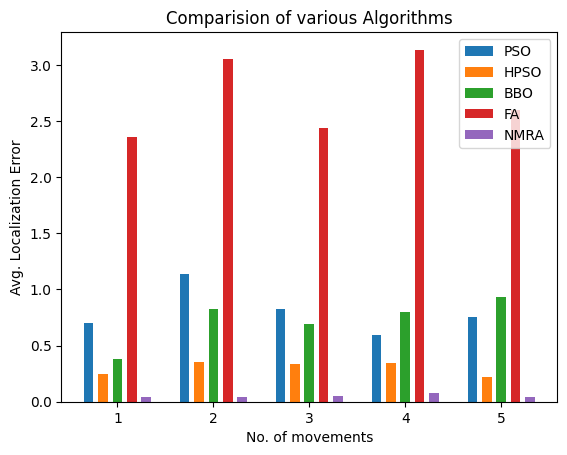

In [ ]:
xaxis = np.arange(1,6)
plt.bar(xaxis - 0.3, PSO_avg_error, 0.10, label = 'PSO')
plt.bar(xaxis - 0.15, HPSO_avg_error, 0.10, label = 'HPSO')
plt.bar(xaxis, BBO_avg_error, 0.10, label = 'BBO')
plt.bar(xaxis + 0.15, FA_avg_error, 0.10, label = 'FA')
plt.bar(xaxis + 0.3, NMRA_avg_error, 0.10, label = 'NMRA')
plt.legend()
plt.xlabel('No. of movements')
plt.ylabel('Avg. Localization Error')
plt.xticks(xaxis)
plt.title("Comparision of various Algorithms")
plt.show()

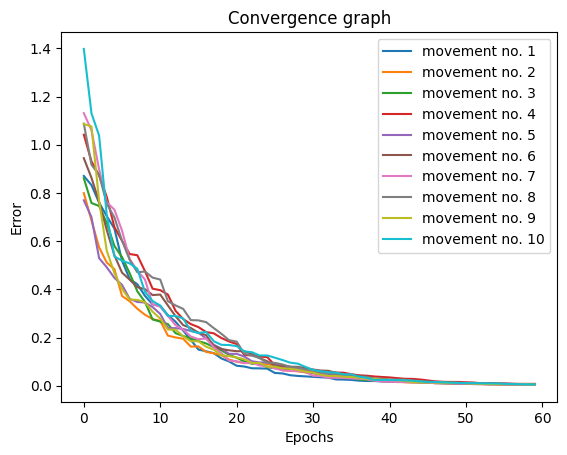

In [ ]:
error_convergence = []

for i in range(len(error_overall)):
    temp = np.zeros(60)
    for j in range(len(error_overall[i])):
        for k in range(len(error_overall[i][j])):
            temp[k]+=error_overall[i][j][k]
        
    error_convergence.append(temp/len(error_overall[i]))


error_convergence = np.array(error_convergence)
# print(error_convergence)
xaxis = np.arange(1,61)

for i in range(len(error_convergence)):
    tis= "movement no. " + str(i+1)
    ax = sns.lineplot(error_convergence[i], label = tis)
    ax.set(xlabel="Epochs", ylabel = "Error", title = "Convergence graph")

